**Prepare the Dataset**

Please upload the "uw-cs480-fall20.zip" file to the Files area (in content folder) on Google Colab, and then run this chunk of code. 

In [ ]:
!unzip uw-cs480-fall20.zip

**Preprocess the Dataset**

We will gather our images, texts and corresponding categories for training from the CSV files, and clean the texts by converting all of the characters to lower case and remove the punctuation; in addition, convert the format of each set to proper format to fit the model.

In [2]:
import math
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def clean_text(text):
  translator = str.maketrans(string.punctuation, ' ' * len(string.punctuation)) # map punctuation to space
  new_txt = text.translate(translator)
  new_txt = new_txt.lower() 
  return new_txt

# prepare train dataset
train_data = pd.read_csv("train.csv")
train_data['noisyTextDescription'] = train_data['noisyTextDescription'].apply(clean_text)
train_category = train_data.category
train_id = train_data.id
train_txt = train_data.noisyTextDescription
classification = (pd.unique(train_category)).tolist()
y = list(map(lambda c: np.array([classification.index(c)]), train_category))
cate_train = np.array(y)
train_img = []
for label in train_id:
  img = mpimg.imread('suffled-images/shuffled-images/{}.jpg'.format(label))
  train_img.append(img)
img_train = np.array(train_img)

# prepare test dataset
test_data = pd.read_csv("test.csv")
test_data['noisyTextDescription'] = test_data['noisyTextDescription'].apply(clean_text)
test_id = test_data.id
test_txt = test_data.noisyTextDescription
test_img = []
for label in test_id:
  img = mpimg.imread('suffled-images/shuffled-images/{}.jpg'.format(label))
  test_img.append(img)
img_test= np.array(test_img)

txt_train shape: (21627, 10000)
txt_test shape: (21628, 10000)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
img_train shape: (21627, 80, 60, 3)
cate_train shape: (21627, 1)
img_test shape: (21628, 80, 60, 3)
The image label is:  [0]
The image class is:  Scarves
[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]]
The one hot label is: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]


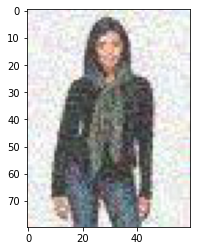

In [3]:
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import text, sequence
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint
from keras.utils import to_categorical

# parameters for this script
batch_size = 32
num_classes = 27
epochs_img = 50
epochs_text = 2
data_augmentation = False

# normalize text dataset
max_words = 10000
tokenize = text.Tokenizer(num_words=max_words, char_level=False)
tokenize.fit_on_texts(train_txt) # only fit on train
txt_train = tokenize.texts_to_matrix(train_txt)
txt_test = tokenize.texts_to_matrix(test_txt)

print('txt_train shape:', txt_train.shape)
print('txt_test shape:', txt_test.shape)


# Print the data type of x_train
print(type(img_train))
# Print the data type of y_train
print(type(cate_train))
# Print the data type of x_test
print(type(img_test))

# Get the shape of x_train
print('img_train shape:', img_train.shape)
# Get the shape of y_train
print('cate_train shape:', cate_train.shape)
# Get the shape of x_train
print('img_test shape:', img_test.shape)

index = 0
img_train[index]
img = plt.imshow(img_train[index])
print('The image label is: ', cate_train[index])
#Print the image class
print('The image class is: ', classification[cate_train[index][0]])

# Convert to categorical
y_train_one_hot = to_categorical(cate_train)
print(y_train_one_hot)
print('The one hot label is:', y_train_one_hot[0])

# normalize the data
img_train = img_train / 255
img_test = img_test / 255

# partition training set into training and validation set
x_validate = img_train[17300:,:]
x_train = img_train[:17300,:]
y_validate = y_train_one_hot[17300:,:]
y_train = y_train_one_hot[:17300,:]

**Define a Convolutional Neural Network for images**



Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 78, 58, 32)        896       
_________________________________________________________________
activation_6 (Activation)    (None, 78, 58, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 76, 56, 32)        9248      
_________________________________________________________________
activation_7 (Activation)    (None, 76, 56, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 38, 28, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 38, 28, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 36, 26, 64)       

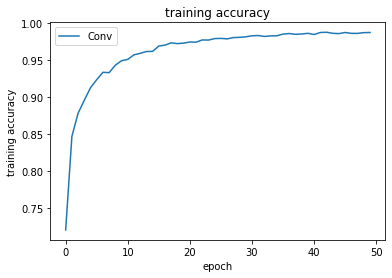

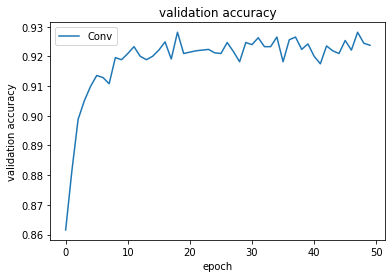

In [24]:
# Define a convolutional neural network
model_img = Sequential()
model_img.add(Conv2D(32, (3, 3), input_shape=(80, 60, 3)))
model_img.add(Activation('relu'))
model_img.add(Conv2D(32, (3, 3)))
model_img.add(Activation('relu'))
model_img.add(MaxPooling2D(pool_size=(2, 2)))
model_img.add(Dropout(0.25))

model_img.add(Conv2D(64, (3, 3)))
model_img.add(Activation('relu'))
model_img.add(Conv2D(64, (3, 3)))
model_img.add(Activation('relu'))
model_img.add(MaxPooling2D(pool_size=(2, 2)))
model_img.add(Dropout(0.25))

model_img.add(Flatten())
model_img.add(Dense(512, activation='relu'))
model_img.add(Dropout(0.5))
model_img.add(Dense(num_classes, activation='softmax'))

# initiate RMSprop optimizer
opt = keras.optimizers.Adam()

# Compile the model before using it
model_img.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
print(model_img.summary())

# create a callback that will save the best model while training
save_best_model_img = ModelCheckpoint('best_model_img.h5', monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)

# train without data augmentation
if not data_augmentation:
    print('Not using data augmentation.')
    history = model_img.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs_img,
                        validation_data=(x_validate, y_validate),
                        shuffle=True,
                        callbacks=[save_best_model_img])

# train with data augmentation
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.1,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.1,
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    history = model_img.fit(datagen.flow(x_train, y_train, batch_size=batch_size),
                        steps_per_epoch=math.ceil(x_train.shape[0]/batch_size),
                        epochs=epochs_img,
                        validation_data=(x_validate, y_validate),
                        callbacks=[save_best_model_img])
    
# Plot training accuracy
plt.plot(history.history['accuracy'])
plt.title('training accuracy')
plt.ylabel('training accuracy')
plt.xlabel('epoch')
plt.legend(['Conv'], loc='upper left')
plt.show()

# Plot validation accuracy
plt.plot(history.history['val_accuracy'])
plt.title('validation accuracy')
plt.ylabel('validation accuracy')
plt.xlabel('epoch')
plt.legend(['Conv'], loc='upper left')
plt.show()

**Define a Sequential Model for texts**

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 512)               5120512   
_________________________________________________________________
activation_4 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 27)                13851     
_________________________________________________________________
activation_5 (Activation)    (None, 27)                0         
Total params: 5,134,363
Trainable params: 5,134,363
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/2
552/557 [============================>.] - ETA: 0s - loss: 0.9135 - accuracy: 0.7768
Epoch 0000

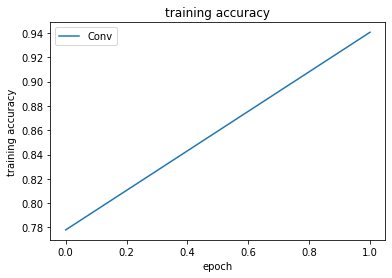

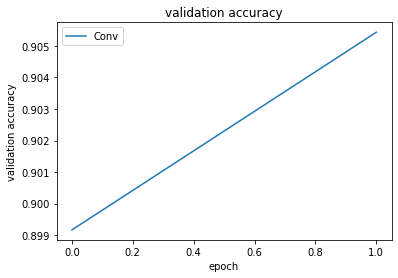

In [22]:
# Build the model
model_txt = Sequential()
model_txt.add(Dense(512, input_shape=(max_words,)))
model_txt.add(Activation('relu'))
model_txt.add(Dropout(0.5))
model_txt.add(Dense(num_classes))
model_txt.add(Activation('softmax'))

# create a callback that will save the best model while training
save_best_model_txt = ModelCheckpoint('best_model_txt.h5', monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)

# initiate RMSprop optimizer
opt = keras.optimizers.Adam()

model_txt.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
print(model_txt.summary())

history = model_txt.fit(txt_train, y_train_one_hot,
                    batch_size=batch_size,
                    epochs=epochs_text,
                    verbose=1,
                    validation_split=0.177,
                    callbacks=[save_best_model_txt])

# Plot training accuracy
plt.plot(history.history['accuracy'])
plt.title('training accuracy')
plt.ylabel('training accuracy')
plt.xlabel('epoch')
plt.legend(['Conv'], loc='upper left')
plt.show()

# Plot validation accuracy
plt.plot(history.history['val_accuracy'])
plt.title('validation accuracy')
plt.ylabel('validation accuracy')
plt.xlabel('epoch')
plt.legend(['Conv'], loc='upper left')
plt.show()

**Ensemble two models and produce the result CSV file**

In [25]:
l = len(img_test)
n = math.ceil(0.21 * l)
saved_model_img = load_model('best_model_img.h5')
img_predictions = saved_model_img.predict(img_test)
pred_prob = np.amax(img_predictions, axis = 1)
classes_img = np.argmax(img_predictions, axis = 1)
idx = (np.argpartition(pred_prob, n))[:n]
txts = []
for i in idx:
  txts.append(txt_test[i])
text_test = np.array(txts)
saved_model_txt = load_model('best_model_txt.h5')
txt_predictions = saved_model_txt.predict(text_test)
classes_txt = np.argmax(txt_predictions, axis = 1)
j = 0
for i in idx:
  classes_img[i] = classes_txt[j]
  j += 1
predicted_categories = list(map(lambda i: classification[i], classes_img))
result = {"id":test_id, "category":predicted_categories}
df = pd.DataFrame(result)
df.to_csv('submission.csv', index=False)
